In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'   
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
            device = '/gpu:0'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-09-11 18:27:53.421815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 18:27:53.436002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 18:27:53.449545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 18:27:53.453456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 18:27:53.464789: I tensorflow/core/platform/cpu_feature_guar

device /gpu:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import tqdm
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64
        
        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)

In [4]:

def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                
                c='red', marker='o',s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=3e-5, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def resnet34(self, input_shape=(64, 64, 1), num_classes=5):
        """ResNet34 Architecture."""
        bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

        inputs = layers.Input(shape=input_shape)

        # Initial conv + max pool
        x = layers.Conv2D(64, 7, strides=2, padding='same', name='conv1_conv')(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name='conv1_bn')(x)
        x = layers.ReLU(name='conv1_relu')(x)
        x = layers.MaxPooling2D(3, strides=2, padding='same', name='pool1_pool')(x)

        # Conv2_x
        x = conv_block(x, 64, stride=1, conv_shortcut=False, name='conv2_block1')
        x = identity_block(x, 64, name='conv2_block2')
        x = identity_block(x, 64, name='conv2_block3')

        # Conv3_x
        x = conv_block(x, 128, stride=2, name='conv3_block1')
        x = identity_block(x, 128, name='conv3_block2')
        x = identity_block(x, 128, name='conv3_block3')
        x = identity_block(x, 128, name='conv3_block4')

        # Conv4_x
        x = conv_block(x, 256, stride=2, name='conv4_block1')
        x = identity_block(x, 256, name='conv4_block2')
        x = identity_block(x, 256, name='conv4_block3')
        x = identity_block(x, 256, name='conv4_block4')
        x = identity_block(x, 256, name='conv4_block5')
        x = identity_block(x, 256, name='conv4_block6')

        # Conv5_x
        x = conv_block(x, 512, stride=2, name='conv5_block1')
        x = identity_block(x, 512, name='conv5_block2')
        x = identity_block(x, 512, name='conv5_block3')

        return x, inputs

    def build_model(self):
        x, inputs = self.resnet34(input_shape=self.input_shape, num_classes=self.num_classes)
        
        # Global pooling and additional layers for midpoint prediction
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)

        return models.Model(inputs, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


# Define helper functions for conv_block and identity_block (from Model B)
def conv_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A block with convolution layers that can optionally downsample the input."""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = layers.ReLU(name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.ReLU(name=name + '_out')(x)
    return x

def identity_block(x, filters, kernel_size=3, name=None):
    """A block that preserves input size."""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    shortcut = x

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = layers.ReLU(name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.ReLU(name=name + '_out')(x)
    return x


In [6]:
import tensorflow as tf

class SimpleCyclicLR(tf.keras.callbacks.Callback):
    """A simple Cyclic Learning Rate (CLR) callback."""

    def __init__(self, base_lr=1e-4, max_lr=1e-2, step_size=2000, mode='triangular'):
        super(SimpleCyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iterations = 0
        self.history = {}

    def clr(self):
        """Calculate learning rate according to the current iteration."""
        cycle = tf.floor(1 + self.iterations / (2 * self.step_size))
        x = tf.abs(self.iterations / self.step_size - 2 * cycle + 1)
        learning_rate = self.base_lr + (self.max_lr - self.base_lr) * tf.maximum(0., (1 - x))
        return learning_rate

    def on_train_begin(self, logs=None):
        """Set the learning rate to the base_lr at the start of training."""
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.base_lr)

    def on_batch_end(self, batch, logs=None):
        """Update the learning rate after each batch."""
        self.iterations += 1
        learning_rate = self.clr()
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate)
        self.history.setdefault('lr', []).append(learning_rate)

        # Optional: Print current learning rate for visibility
        print(f"Iteration {self.iterations}: Learning rate is {learning_rate:.6f}")


In [7]:


h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KPadded_Mixed_5.h5' ### for more challenging train

data_loader = DataLoader(h5_filename)

images, centers = data_loader.load_data()


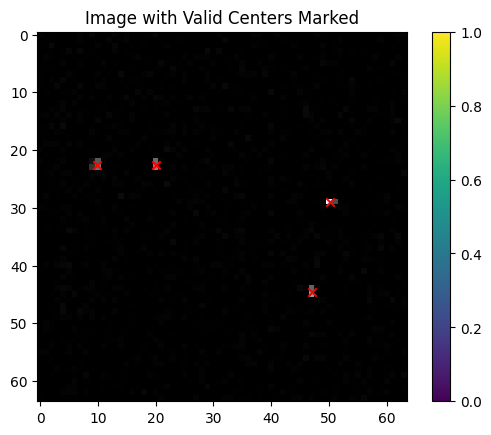

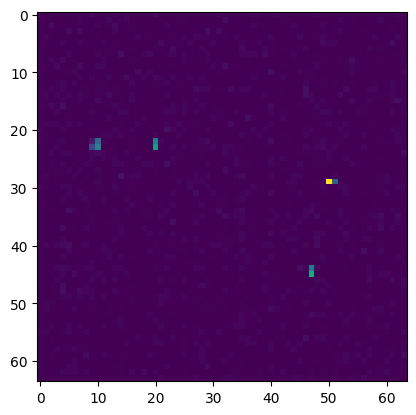

In [8]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [9]:
# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 5, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 5, 2)


2024-09-11 18:29:17.311809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0


In [10]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

batch_size = 200
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)


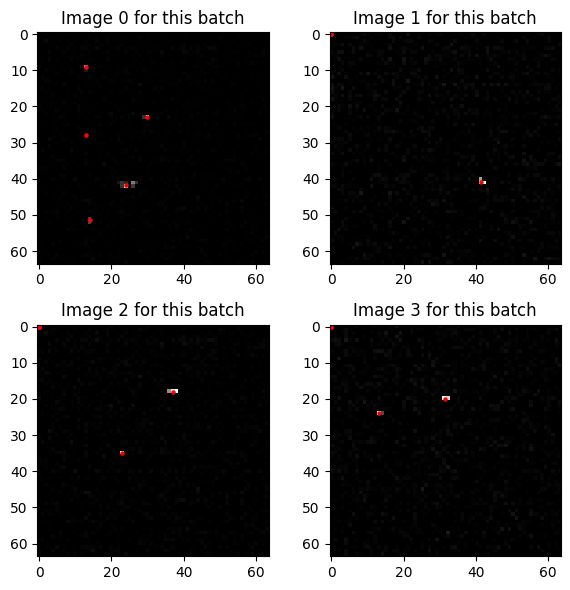

In [15]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [11]:
# Initialize the ModelBuilder
model_builder = ModelBuilder()

# Build the model
model = model_builder.build_model()

# # Display the model architecture
# model.summary()

In [26]:
train_outputs = model_builder.model.predict(train_dataset)
val_outputs = model_builder.model.predict(val_dataset)

I0000 00:00:1726079234.656592 3543603 service.cc:146] XLA service 0x7f28a0002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726079234.656657 3543603 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-09-11 18:27:14.719376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-11 18:27:15.007394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 34/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1726079236.469546 3543603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
train_outputs.shape,val_outputs.shape

((24000, 1, 5, 2), (6000, 1, 5, 2))

In [17]:
len(train_dataset)

120

In [12]:
# model_builder = ModelBuilder()
# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 100)
# model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))
clr_callback = SimpleCyclicLR(base_lr=1e-7, max_lr=1e-2, step_size=120)
model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError())



In [13]:

history = model_builder.train_model(train_dataset, val_dataset, epochs=110,callbacks_list=[clr_callback])


AttributeError: 'str' object has no attribute 'name'

: 

In [43]:
model.save('mymodifiedresne34.keras')

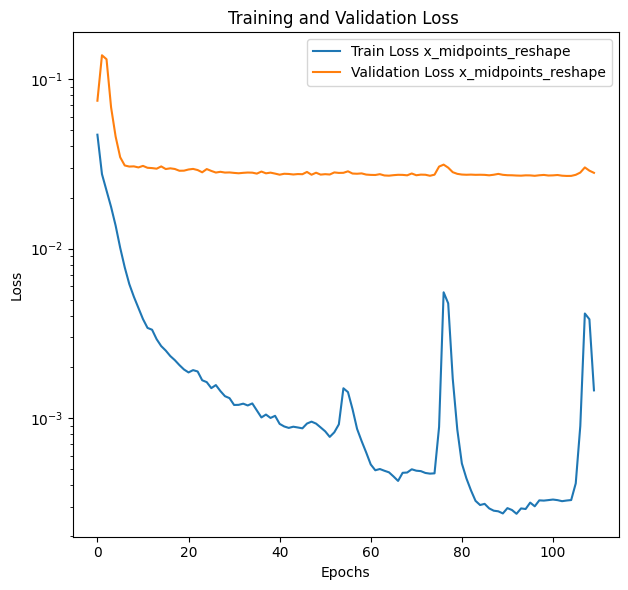

In [19]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 64, 64)
25/2

2024-09-11 18:10:39.140143: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


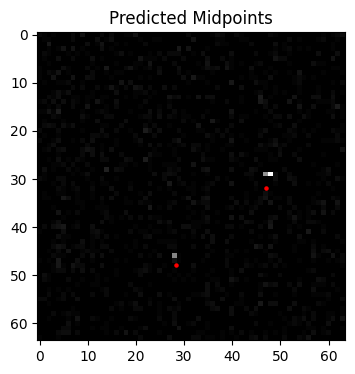

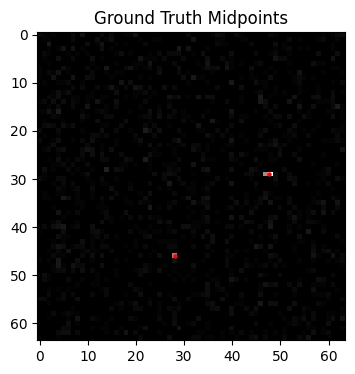

In [42]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


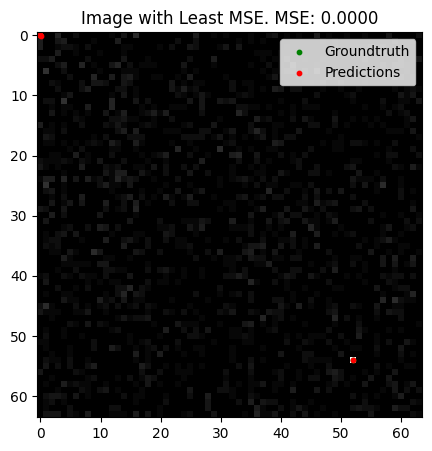

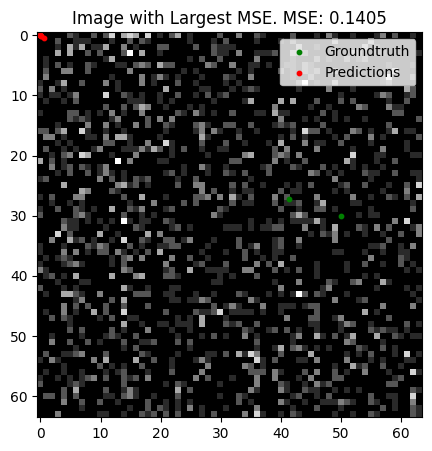

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')


